## Practical work in AI

In [1]:
import numpy as np

from pathlib import Path
import os
from typing import *
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler

import monai
from monai.transforms import *
from monai.config.type_definitions import KeysCollection

import segmentation_models_pytorch as smp

import albumentations as A

import wandb

# Imports from local files
from transforms import *
from dataset import OCTDatasetPrep, MakeDataset
from utils import *


# Set random seed
np.random.seed(99)
torch.manual_seed(99)

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: moritsih. Use `wandb login --relogin` to force relogin


True

## Paths to the data

In [2]:
class Config():

    def __init__(self):

        # paths
        # directory where img folders are still sorted by domain (but unprocessed OCT images)
        self.name_dir = Path(Path.cwd() / 'data/RETOUCH/TrainingSet-Release/') 
        # already processed OCT images but unsorted by domain (sorting happens in dataset class)
        self.train_dir = Path(Path.cwd() / 'data/Retouch-Preprocessed/train') 
        self.model_path = Path(Path.cwd() / 'models')


        self.source_domains = ['Spectralis', 'Topcon', 'Cirrus']


        # transforms
        self.train_transforms = Compose([
                                        CustomImageLoader(keys=['img', 'label']), # if SVDNA should not be performed, uncomment this and comment the following two lines
                                        #SVDNA(keys=['img'], histogram_matching_degree=.5),
                                        #CustomImageLoader(keys=['label']),
                                        ConvertLabelMaskToChannel(keys=['label'], target_keys=["masks"]),
                                        ExpandChannelDim(keys=['img', 'label']),
                                        ToTensord(keys=['img', 'label', 'masks']),
                                        #Lambdad(keys=['img', 'label', 'masks'], func = lambda x: 2*(x - x.min()) / (x.max() - x.min()) - 1 ),  # -1 to 1 scaling
                                        NormalizeToZeroOne(keys=['img', 'label', 'masks']),
                                        Resized(keys=["img", "label", 'masks'], mode=["area", "nearest-exact", "nearest-exact"], spatial_size=[496, 1024]),
                                        SpatialPadd(keys=['img', 'label', 'masks'], spatial_size=[512, 1024], mode='constant'),
                                        #RandZoomd(keys=["img", "label", 'masks'], mode=["area", "nearest-exact", "nearest-exact"], prob=0.3, min_zoom=0.5, max_zoom=1.5),
                                        #RandAxisFlipd(keys=["img", "label", 'masks'], prob=0.3),
                                        #RandAffined(keys=["img", "label", 'masks'], 
                                        #            prob=0.3, 
                                        #            shear_range=[0, 0],
                                        #            translate_range=[0, 0],
                                        #            rotate_range=[0, 0],
                                        #            mode=["bilinear", "nearest", "nearest"], 
                                        #            padding_mode="zeros"),      
                                        #Debugging(keys=['img', 'label', 'masks']),
                                        ])


        self.val_transforms = Compose([
                                        CustomImageLoader(keys=['img', 'label']),
                                        ConvertLabelMaskToChannel(keys=['label'], target_keys=["masks"]),
                                        ExpandChannelDim(keys=['img', 'label']),
                                        ToTensord(keys=['img', 'label', 'masks']),
                                        NormalizeToZeroOne(keys=['img', 'label', 'masks']),
                                        Resized(keys=["img", "label", 'masks'], mode=["area", "nearest-exact", "nearest-exact"], spatial_size=[496, 1024]),
                                        SpatialPadd(keys=['img', 'label', 'masks'], spatial_size=[512, 1024], mode='constant'),
                                        
                                    ])
        
        
        self.test_transforms = Compose([
                                        CustomImageLoader(keys=['img', 'label']),
                                        ConvertLabelMaskToChannel(keys=['label'], target_keys=["masks"]),
                                        ExpandChannelDim(keys=['img', 'label']),
                                        ToTensord(keys=['img', 'label', 'masks']),
                                        NormalizeToZeroOne(keys=['img', 'label', 'masks']),
                                        Resized(keys=["img", "label", 'masks'], mode=["area", "nearest-exact", "nearest-exact"], spatial_size=[496, 1024]),
                                        SpatialPadd(keys=['img', 'label', 'masks'], spatial_size=[512, 1024], mode='constant'),
                                    ])

        # device
        if torch.backends.mps.is_available():
            self.device = 'mps'
        elif torch.cuda.is_available():
            self.device = 'cuda'
        else:
            self.device = 'cpu'

        # models
        self.model_parameters_unet = {
            'spatial_dims': 2,
            'in_channels': 1,
            'out_channels': 3,
            'channels': (16, 32, 64, 128, 256),
            'strides': (2, 2, 2, 2),
            'num_res_units': 2,
            'bias': False,
            'dropout':0.1
        }


        self.encoder_name = "resnet18"


        # optimizer

        self.lr = 1e-4
        self.weight_decay = 0.003


        # hyperparams
        self.batch_size = 3
        self.epochs = 100




In [3]:
# leftover transforms I keep for later
'''
    #GetMaskPositions(keys=['masks'], target_keys=["mask_positions"]), #We get the layer position, but on the original height
    #LayerPositionToProbabilityMap(["mask_positions"], target_size=(400,400), target_keys=["mask_probability_map"]),

    #Resized(keys=["img", "label", "masks"], mode=["area", "nearest-exact", "nearest-exact"], spatial_size=[400, 400]),
    #Lambdad(keys=['mask_positions'], func = lambda x: x * 400 / 800), #We scale down the positions to have more accurate positions
    #Lambdad(keys=['img'], func = lambda x: np.clip((x - x.mean()) / x.std(), -1, 1)), 
'''

'\n    #GetMaskPositions(keys=[\'masks\'], target_keys=["mask_positions"]), #We get the layer position, but on the original height\n    #LayerPositionToProbabilityMap(["mask_positions"], target_size=(400,400), target_keys=["mask_probability_map"]),\n\n    #Resized(keys=["img", "label", "masks"], mode=["area", "nearest-exact", "nearest-exact"], spatial_size=[400, 400]),\n    #Lambdad(keys=[\'mask_positions\'], func = lambda x: x * 400 / 800), #We scale down the positions to have more accurate positions\n    #Lambdad(keys=[\'img\'], func = lambda x: np.clip((x - x.mean()) / x.std(), -1, 1)), \n'

## Initialize Config

In [4]:
cfg = Config()
#cfg.device = "cpu"

In [5]:
train_data_raw, val_data_raw, test_data_raw = OCTDatasetPrep(cfg.train_dir, source_domains=cfg.source_domains).get_datasets(use_official_testset=True)

Total dataset length:  9131
Training set: 3506
Validation set: 1502
Test set: 4123


In [5]:
print_some_imgs = False

if print_some_imgs:
    
    transforms_visualize = Compose([cfg.train_transforms])
    #transforms_visualize = Compose([cfg.train_transforms, ImageVisualizer(keys=['img', 'label', 'masks'])])
    train_data_raw, _, _ = OCTDatasetPrep(cfg.train_dir, source_domains=cfg.source_domains).get_datasets(use_official_testset=False)
    train_data = MakeDataset(train_data_raw, transforms_visualize)


    for i in range(4):
 
        rand_num = np.random.randint(0, len(train_data))
        sample = train_data[rand_num]
        print(f"Sample {i+1}", 
              "\nImg: ", sample['img'].shape,
              "\nLabel: ", sample['label'].shape,
              "\nMasks: ", sample['masks'].shape)




## Architecture, dataset, loss function, optimizer

In [6]:
def get_model(cfg):

    return smp.UnetPlusPlus(encoder_name=cfg.encoder_name,
                             encoder_weights="imagenet",
                             decoder_channels = (1024, 512, 256, 128, 64),
                             in_channels=1,
                             classes=4,
                             decoder_attention_type="scse")

In [7]:
if not os.path.isdir('models'):
    os.mkdir('models')

if not os.path.isdir('val_predictions'):
    os.mkdir('val_predictions')


print("Device: ", cfg.device)


#model = monai.networks.nets.UNet(**cfg.model_parameters_unet).to(cfg.device)
model = get_model(cfg).to(cfg.device)


#include background is important: we don't want the large amount of background pixels to dominate the loss
criterion = monai.losses.DiceCELoss(include_background=True,
                                    sigmoid=True)

optimizer = optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)


# plotting LR at bottom of the notebook
#start_lr = 1
#end_lr = 1

#scheduler1 = lr_scheduler.LinearLR(optimizer, start_lr, end_lr)
#scheduler2 = lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.epochs/7, eta_min=5e-2) # cycle 7 times during training

#scheduler = lr_scheduler.SequentialLR(optimizer, schedulers=[scheduler1, scheduler2], milestones=[30]) # switch to Cosine after 50 epochs

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=5)

train_data, val_data, _ = OCTDatasetPrep(cfg.train_dir).get_datasets(dataset_split=[0.01, 0.003])

train_dataset = MakeDataset(train_data, cfg.train_transforms)
val_dataset = MakeDataset(val_data, cfg.val_transforms)
#test_dataset = MakeDataset(test_data, cfg.test_transforms)

train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=0)
#test_loader = DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=0)


Device:  mps
Training set: 50
Validation set: 15
Test set: 4943


In [8]:
plot_some_more_imgs = False

if plot_some_more_imgs:
    for i, batch in enumerate(train_loader):
        print("img: ", batch['img'].shape)
        print("label: ", batch['label'].shape)
        print("masks: ", batch['masks'].shape)

        # plot each of the images
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(batch['img'][0, 0], cmap='gray')
        ax[0].set_title('Image')
        ax[1].imshow(batch['label'][0, 0], cmap='gray')
        ax[1].set_title('Label')
        ax[2].imshow(np.transpose(batch['masks'][0, 1:], (1, 2, 0)))
        ax[2].set_title('Masks')

        plt.show()

In [9]:
'''
# Run a sample input through the model
sample = next(iter(train_loader))
print(type(sample['img']))
print({k: v.shape for k, v in sample.items()})
sample_input = sample['img'].to(cfg.device)  # assuming 'image' is the key for images
sample_output = model(sample_input)

print(sample_output.shape)

# Compute the loss for a sample output and a sample target
sample_target = sample['masks'].to(cfg.device)  # assuming 'label' is the key for labels
sample_loss = criterion(sample_output, sample_target)
print(sample_loss)'''

"\n# Run a sample input through the model\nsample = next(iter(train_loader))\nprint(type(sample['img']))\nprint({k: v.shape for k, v in sample.items()})\nsample_input = sample['img'].to(cfg.device)  # assuming 'image' is the key for images\nsample_output = model(sample_input)\n\nprint(sample_output.shape)\n\n# Compute the loss for a sample output and a sample target\nsample_target = sample['masks'].to(cfg.device)  # assuming 'label' is the key for labels\nsample_loss = criterion(sample_output, sample_target)\nprint(sample_loss)"

In [10]:
'''
pred = torch.sigmoid(sample_output)

# thresholding
pred[pred > 0.5] = 1
pred[pred <= 0.5] = 0

plot_img_label_pred(sample_input, pred, sample_target)'''

'\npred = torch.sigmoid(sample_output)\n\n# thresholding\npred[pred > 0.5] = 1\npred[pred <= 0.5] = 0\n\nplot_img_label_pred(sample_input, pred, sample_target)'

## Run the thing

In [11]:
train_the_thing = False

if train_the_thing:

    model = load_model(model, cfg.model_path / 'model_trial_withbg.pth')

    wandb_config = {
        'batch_size': cfg.batch_size,
        'lr': optimizer.param_groups[0]['lr'],
        'epochs': cfg.epochs,
        'device': cfg.device,
        'model': 'UNet++ Resnet18 encoder',
        'dataset': 'Retouch',
        'model_parameters': cfg.model_parameters_unet,
    }

    with wandb.init(project='PracticalWorkinAI', 
                    config=wandb_config,
                    name='smp Unet++ small dataset and bg') as run:
        wandb_config = wandb.config
        
        model = train(model, 
                    train_loader, val_loader, 
                    criterion, optimizer, scheduler, cfg.device, 
                    epochs=cfg.epochs, 
                    save_path= cfg.model_path / 'model_trial_withbg.pth')

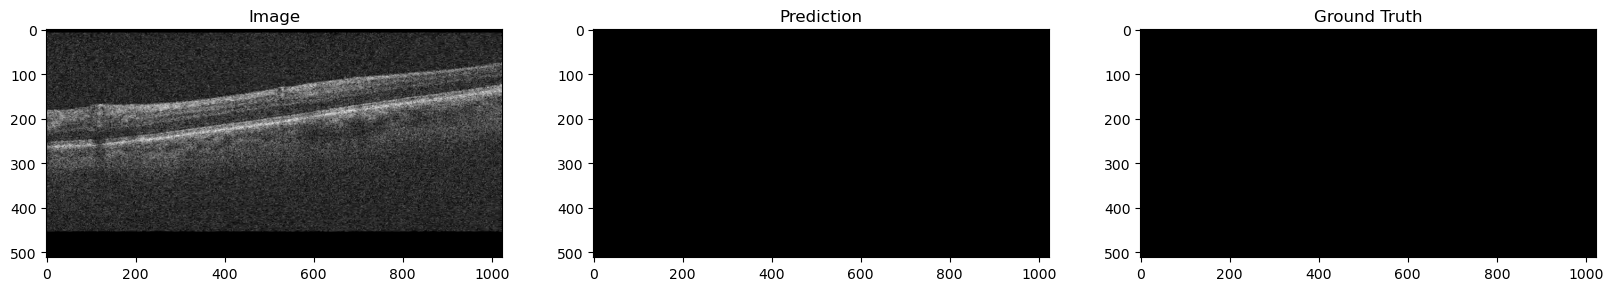

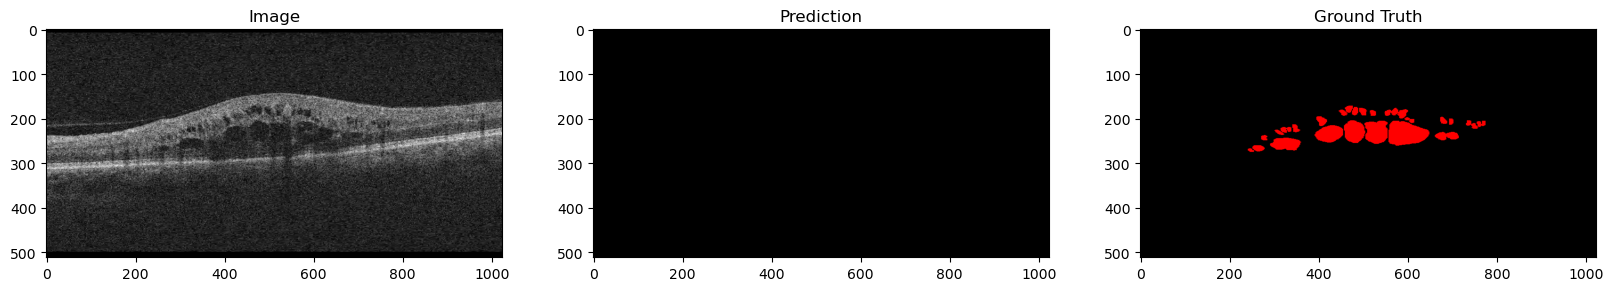

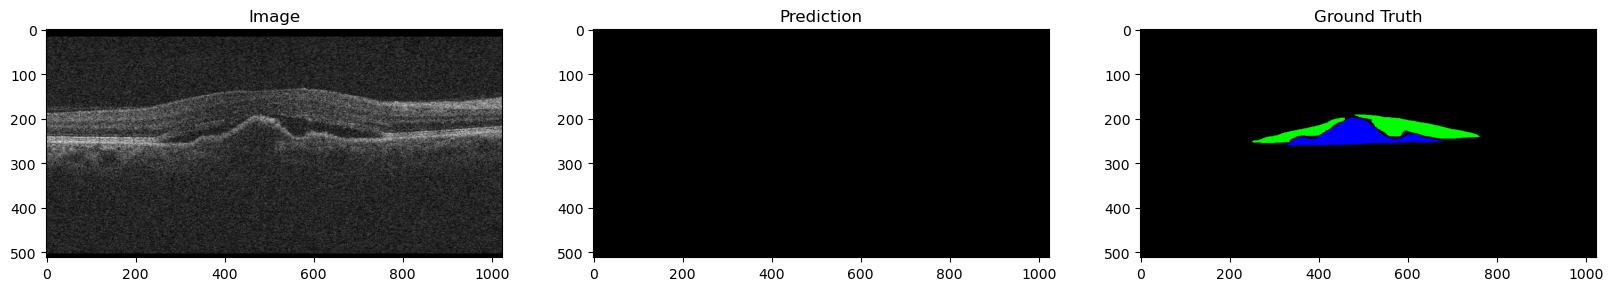

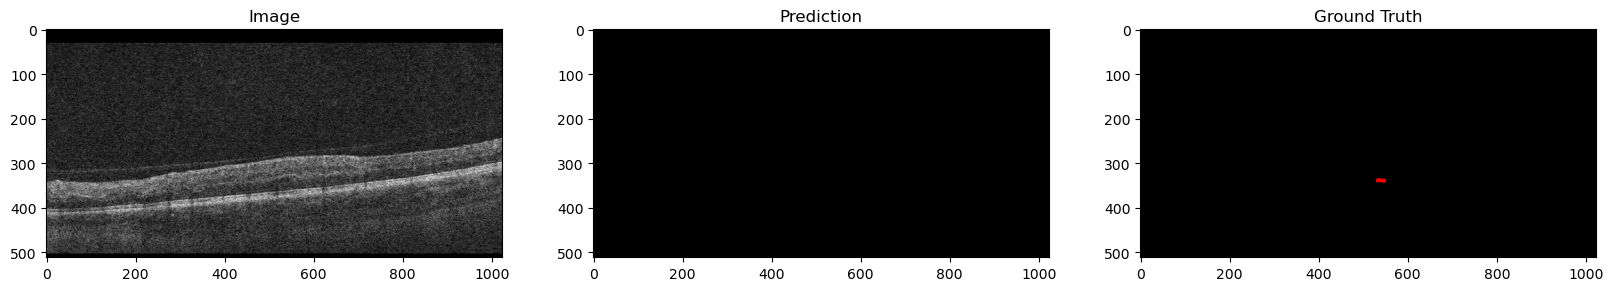

In [12]:
# load saved model and make predictions on random images from the validation set
model = load_model(model, cfg.model_path / 'model_trial.pth')
model.eval()

for i in range(4):
    rand_num = np.random.randint(0, len(val_dataset))
    sample = val_dataset[rand_num]

    img = sample['img'].unsqueeze(0).to(cfg.device)
    mask = sample['masks'].unsqueeze(0).to(cfg.device)

    pred = model(img)
    pred = torch.sigmoid(pred)
    
    # thresholding
    pred[pred > 0.5] = 1
    pred[pred <= 0.5] = 0

    plot_img_label_pred(img, pred, mask)

/Users/moritz/miniconda3/envs/optima/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


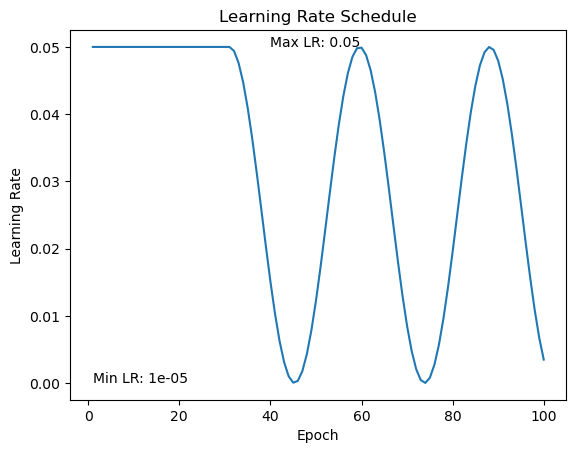

In [13]:
def plot_lr(optimizer, scheduler, num_steps):
    
    lr_values = []
    fake_val_loss = np.arange(1e-4, 2, 1e-2)[::-1]

    for i in range(num_steps):
        lr = scheduler.get_last_lr()

        lr_values.append(lr)
        optimizer.step()
        scheduler.step()

    # Plot the learning rate values
    plt.plot(range(1, num_steps+1), lr_values)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')

    # Add the maximum and minimum learning rate values
    max_lr = max(lr_values)[0]
    min_lr = min(lr_values)[0]

    plt.text(40, max_lr, f'Max LR: {max_lr}')
    plt.text(1, np.round(min_lr,5), f'Min LR: {np.round(min_lr,5)}')

    plt.show()

model = monai.networks.nets.UNet(**cfg.model_parameters_unet)
optimizer = optim.Adam(model.parameters(), lr=5e-2)


start_lr = 1
end_lr = 1

scheduler1 = lr_scheduler.LinearLR(optimizer, start_lr, end_lr)
scheduler2 = lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.epochs/7, eta_min=1e-6) # cycle 7 times during training

scheduler = lr_scheduler.SequentialLR(optimizer, schedulers=[scheduler1, scheduler2], milestones=[30]) # switch to Cosine after 50 epochs

plot_lr(optimizer, scheduler, 100)